In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
from fastai import *
from fastai.vision import *

In [2]:
from pathlib import Path

In [4]:
path = Path('data/')

In [5]:
path_lbl = path/'road'
path_img = path/'sat'

In [6]:
from PIL import Image

In [7]:
import cv2
import numpy as np

def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [8]:
def convert_to_mask(fpath, thres=10):
    im = read_image(fpath)
    immsk = 1 * (im > 10)
    immsk = Image.fromarray(immsk[:,:,0].astype(np.uint8))
    immsk.save(fpath)
    return None

In [9]:
for fpath in list((path/'road').iterdir()):
    convert_to_mask(str(fpath))

## Data

In [12]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/sat/76_brooklyn_sat.png'),
 PosixPath('data/sat/304_queens_sat.png'),
 PosixPath('data/sat/235_napa_sat.png')]

In [13]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/road/97_napa_road.png'),
 PosixPath('data/road/94_napa_road.png'),
 PosixPath('data/road/196_napa_road.png')]

In [14]:
len(lbl_names)

979

torch.Size([3, 512, 512])


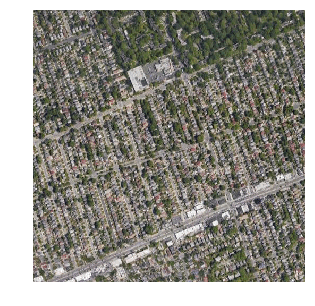

In [17]:
img_f = fnames[200]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(5,5))

poor choice of naming

In [18]:
get_y_fn = lambda x: Path('/'.join(['data', 'road'] + ['_'.join(str(x).split('/')[-1].split('_')[:-1] + ['road.png'])]))

In [19]:
get_y_fn(img_f)

PosixPath('data/road/218_queens_road.png')

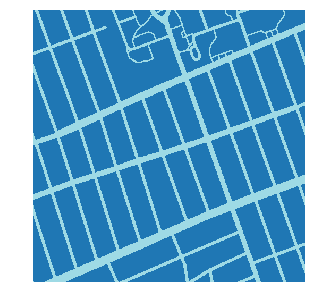

In [20]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [21]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([512, 512]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [1, 0, 0,  ..., 0, 0, 0],
          [1, 0, 0,  ..., 0, 0, 0]]]))

Need to find out all the codes present

## Datasets

Create a list of test images choosing randomly

In [27]:
#!ls sat/ | shuf -n 47 > test.txt

In [22]:
size = src_size//2
bs = 8

In [23]:
codes = np.array(['not-road', 'road'])

Randomly selecting some data for testing and writing the name into a file

In [24]:
!cat data/test.txt

29_brooklyn_sat.png
261_queens_sat.png
209_napa_sat.png
135_napa_sat.png
82_queens_sat.png
24_napa_sat.png
112_brooklyn_sat.png
209_queens_sat.png
269_queens_sat.png
204_napa_sat.png
167_brooklyn_sat.png
203_brooklyn_sat.png
37_queens_sat.png
185_queens_sat.png
260_queens_sat.png
73_sf_sat.png
8_sf_sat.png
162_napa_sat.png
305_queens_sat.png
237_queens_sat.png
138_napa_sat.png
141_queens_sat.png
138_queens_sat.png
165_brooklyn_sat.png
18_napa_sat.png
128_brooklyn_sat.png
61_sf_sat.png
23_napa_sat.png
286_queens_sat.png
312_queens_sat.png
33_sf_sat.png
275_queens_sat.png
57_sf_sat.png
14_queens_sat.png
80_sf_sat.png
193_brooklyn_sat.png
21_brooklyn_sat.png
295_queens_sat.png
99_napa_sat.png
124_queens_sat.png
220_queens_sat.png
144_brooklyn_sat.png
196_napa_sat.png
55_brooklyn_sat.png
143_sf_sat.png
90_sf_sat.png
286_napa_sat.png
12_sf_sat.png
13_queens_sat.png


In [25]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../test.txt')
       .label_from_func(get_y_fn, classes=codes))

In [26]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

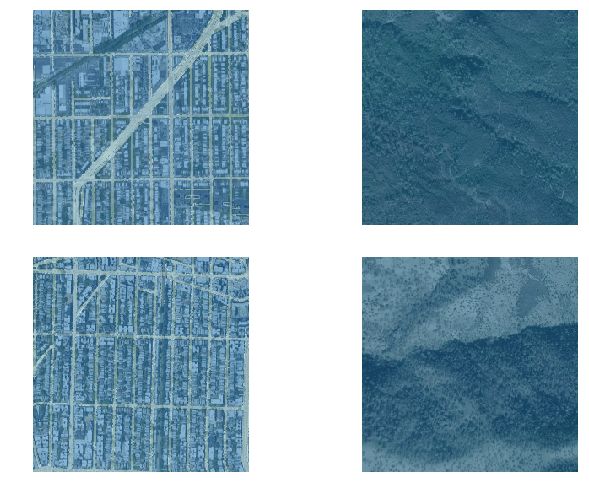

In [27]:
data.show_batch(2, figsize=(10,7))

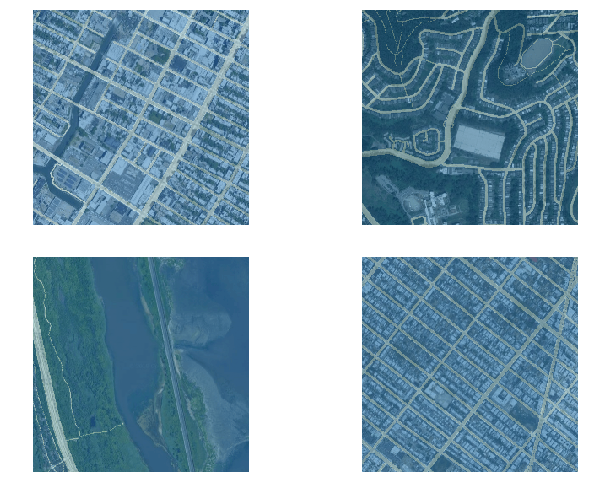

In [28]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [29]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_map(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [30]:
metrics=acc_map
# metrics=accuracy

In [31]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


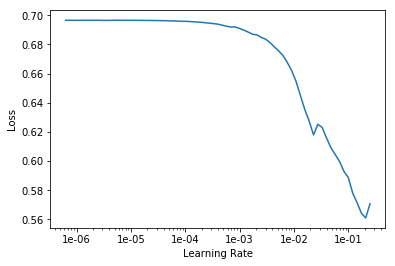

In [32]:
lr_find(learn)
learn.recorder.plot()

In [33]:
lr=1e-3

In [34]:
learn.fit_one_cycle(10, slice(lr))

Total time: 03:02
epoch  train_loss  valid_loss  acc_map 
1      0.605215    0.566882    0.844891  (00:22)
2      0.316525    0.218093    0.911296  (00:17)
3      0.233666    0.220111    0.909752  (00:17)
4      0.215683    0.203692    0.916622  (00:17)
5      0.200378    0.185283    0.926121  (00:17)
6      0.198760    0.175726    0.929273  (00:17)
7      0.185392    0.170500    0.931388  (00:17)
8      0.176080    0.168195    0.932532  (00:17)
9      0.179900    0.164654    0.934304  (00:17)
10     0.175221    0.165057    0.933978  (00:17)



In [35]:
learn.save('stage-1')

In [36]:
learn.load('stage-1');

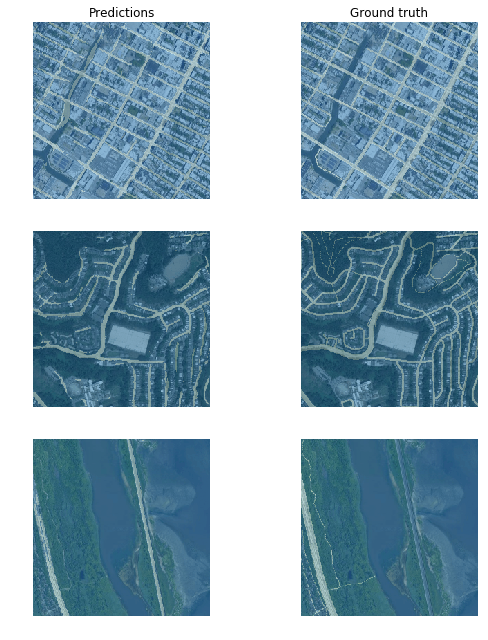

In [37]:
learn.show_results()

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


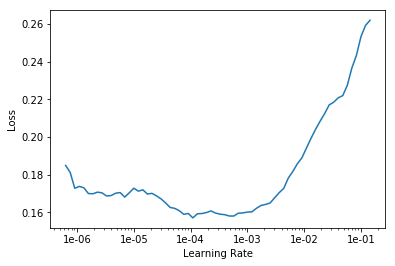

In [39]:
lr_find(learn)
learn.recorder.plot()

In [40]:
lrs = slice(1e-5, 1e-4 / 2)

In [41]:
learn.fit_one_cycle(12, lrs)

Total time: 04:21
epoch  train_loss  valid_loss  acc_map 
1      0.170205    0.163958    0.934375  (00:21)
2      0.168142    0.164452    0.934097  (00:21)
3      0.170081    0.163551    0.934519  (00:21)
4      0.170234    0.163941    0.934687  (00:21)
5      0.171189    0.163360    0.934514  (00:21)
6      0.165877    0.165506    0.934189  (00:21)
7      0.170358    0.162687    0.934722  (00:21)
8      0.168610    0.162819    0.934818  (00:21)
9      0.163695    0.161863    0.935118  (00:21)
10     0.170061    0.162777    0.934975  (00:21)
11     0.166626    0.161696    0.935353  (00:21)
12     0.174646    0.162891    0.934918  (00:21)



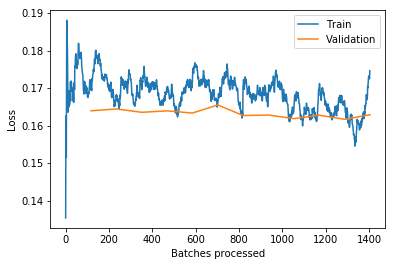

In [42]:
learn.recorder.plot_losses()

In [43]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [44]:
size = src_size
bs=4

In [45]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [46]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [47]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


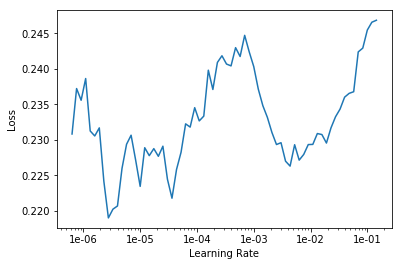

In [48]:
lr_find(learn)
learn.recorder.plot()

In [49]:
lr=1e-6

In [50]:
learn.fit_one_cycle(5, slice(lr))

Total time: 05:00
epoch  train_loss  valid_loss  acc_map 
1      0.244709    0.239625    0.908060  (01:09)
2      0.236252    0.235190    0.909671  (00:57)
3      0.239835    0.225724    0.912130  (00:57)
4      0.231171    0.222703    0.913047  (00:57)
5      0.226812    0.221100    0.913489  (00:57)



In [51]:
lr = 1e-5 / 2
learn.fit_one_cycle(5, slice(lr))

Total time: 04:48
epoch  train_loss  valid_loss  acc_map 
1      0.228889    0.211658    0.916144  (00:57)
2      0.210016    0.196296    0.921396  (00:57)
3      0.210954    0.190527    0.923444  (00:57)
4      0.210895    0.186342    0.924461  (00:58)
5      0.195712    0.187853    0.924514  (00:57)



In [52]:
learn.save('stage-1-big')

In [53]:
learn.load('stage-1-big');

In [54]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


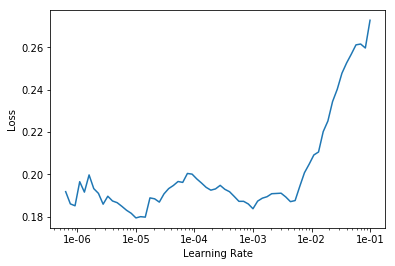

In [55]:
lr_find(learn)
learn.recorder.plot()

In [56]:
lrs = slice(1e-6, lr)

In [57]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 11:23
epoch  train_loss  valid_loss  acc_map 
1      0.201594    0.185551    0.925381  (01:07)
2      0.197812    0.180207    0.926949  (01:07)
3      0.194930    0.176732    0.928520  (01:08)
4      0.193297    0.174518    0.929491  (01:08)
5      0.185821    0.171775    0.930812  (01:08)
6      0.190950    0.172008    0.930799  (01:08)
7      0.179618    0.171618    0.930974  (01:08)
8      0.179212    0.169353    0.931737  (01:08)
9      0.182954    0.168677    0.932050  (01:08)
10     0.186421    0.168764    0.931879  (01:08)



In [58]:
learn.save('stage-2-big')

In [54]:
#learn.load('stage-2-big')

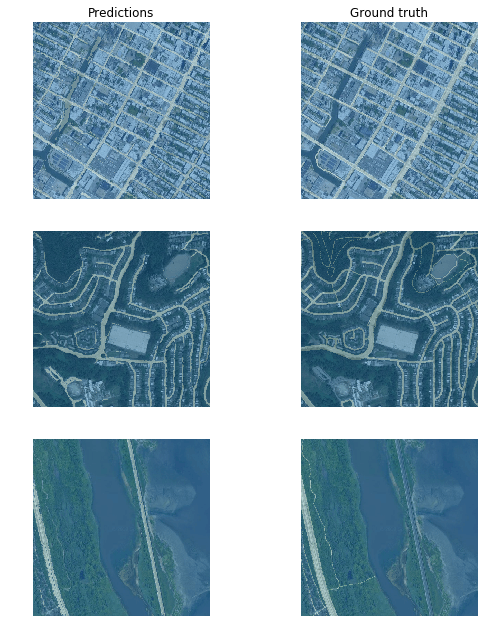

In [59]:
learn.show_results()